*This notebook is created from the  [nbtplt](https://github.com/forforf/pycharm-jupyter-templates) templating engine*

# Train model on kss events

## Model: Logistic Regression

In [1]:
import numpy as np

from config import Project
from src.audio import Audio
from src.kss_df import make_kss_df_cls
from src.model_plot import ModelPlot
from src.shared_params import SharedParams
from src.training_storage import RmsTrainingStorage
from src.transformers.sliding_window import SlidingWindow

In [2]:
# Common wrapper for SciKitLearn models
from src.model_wrapper import ModelWrapper

In [3]:
from sklearn.ensemble import AdaBoostClassifier

In [4]:
# Setup

# Import Korean Fonts
k_prop = Project.setup_font()

# Configure matplotlib
plt = Project.setup_plot()

# Display handler with some nice helpers
disp = Project.setup_display()
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

## Load Training Data

In [5]:
X_train, y_train, _ = X_train, y_train, _ = RmsTrainingStorage(Project.path.MODEL).load()

disp.obj(X_train, label='X')
disp.obj(y_train, label='y')
disp.obj((X_train.shape, np.mean(X_train)), label='X shape, mean' )
disp.obj((y_train.shape, np.mean(y_train)), label='y shape, mean')

X

array([7.2832445e-05, 8.1853534e-05, 8.1345970e-05, ..., 1.6493888e-03,
       1.9856682e-03, 2.1819461e-03], dtype=float32)

y

array([False, False, False, ..., False, False, False])

X shape, mean

((8895,), 0.23018801)

y shape, mean

((8895,), 0.818999437886453)

## Train Model and Save

In [6]:
feature_transformer = SlidingWindow(window=128, offset_percent=0.75)
disp.obj(feature_transformer, label='Feature Transformer')

Feature Transformer

SlidingWindow(offset_percent=0.75, window=128)

In [7]:
model_id = 'ada'
model = AdaBoostClassifier()

In [8]:
print(X_train.size)
print(y_train.size)

8895
8895


In [9]:
wrapper = ModelWrapper(model_id, model, transformer=feature_transformer, save_dir=Project.path.MODEL)
print(X_train.size)
print(y_train.size)
wrapper.fit(X_train, y_train)

wrapper.save()
wrapper_saved = wrapper.load(wrapper.get_current_wrapper_path())
wrapper.remove_old_versions(keep=3)

ModelWrapper[INFO]: fitting using model: AdaBoostClassifier()
SlidingWindow[INFO]: np sliding window shape: (9087, 128)
ModelWrapper[INFO]: transformed X, y shapes: (8895, 128), (8895,)


8895
8895


FileVersioner[INFO]: Bumped version to 3
FileVersioner[INFO]: Bumped version to 2
FileVersioner[INFO]: Bumped version to 2


## Evaluate Training

Evaluate the training data by seeing if our trained model will predict close to the data it was trained on.

Validation will come later

This is just to make sure our Model trained correctly. It might have overfit, but we don't care yet.

In [10]:
y_train_pred = wrapper_saved.predict(X_train)
shared_params = SharedParams(Project.path.MODEL).load()

disp.obj(shared_params)

SlidingWindow[INFO]: np sliding window shape: (9087, 128)
ModelWrapper[INFO]: transformed X, y shapes: (8895, 128), (8895,)


{'kss': {'trn_ids': ['1_0000', '1_0001', '1_0002', '1_0003', '1_0004'],
  'tst_ids': ['1_0005', '1_0006']},
 'audio': {'n_fft': 256, 'n_hops': 4, 'n_mfcc': 3, 'sr': 44100}}

In [11]:
# remove kss_ids from params just to keep things a bit cleaner
kss_ids = shared_params['kss']['trn_ids']
print(kss_ids)
audio_params = shared_params['audio']
# iterate over each kss_id, find the audio file, load it and return it's squeezed rms
KssDf = make_kss_df_cls(Project.path.TEXTGRID, Project.path.KSSCSV)
x_rms = np.concatenate([Audio(KssDf(id).audio_path, **audio_params).rms.squeeze() for id in kss_ids])

model_txfm = wrapper_saved.transformer

/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[WARNING]: Modifying input wav from size 175173 to 175232
Audio[WARNING]: Modifying input wav from size 77573 to 77632
Audio[WARNING]: Modifying input wav from size 101762 to 101824
Audio[WARNING]: Modifying input wav from size 58741 to 58752


['1_0000', '1_0001', '1_0002', '1_0003', '1_0004']


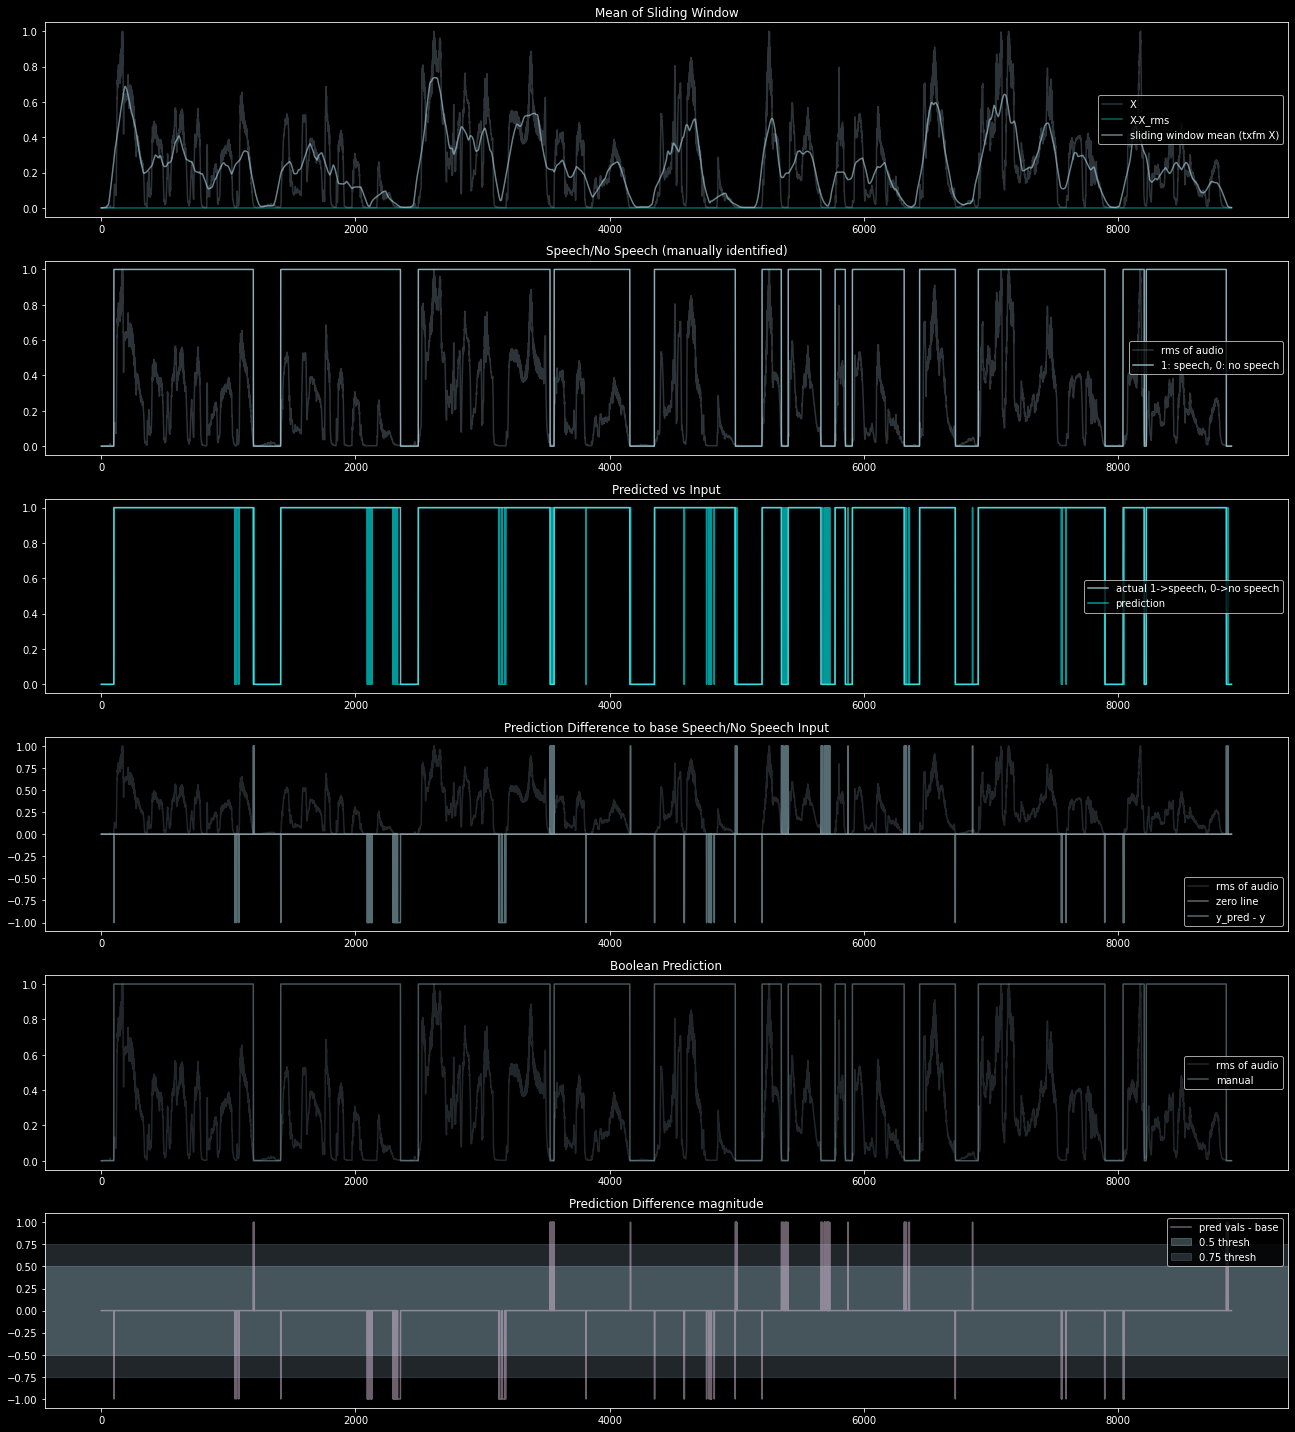

In [12]:
ModelPlot.plot(X_train, y_train, y_train_pred, x_rms, model_txfm)